<a href="https://colab.research.google.com/github/arfafax/StyleGAN2_experiments/blob/master/arfafax_Tag_Based_Anime_Generation_(Public_Twitter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tag-Based Anime Generation

This model uses `doc2vec` embeddings of danbooru tags, combined with a conditional StyleGAN2 model, to generate anime characters based on tag inputs. 

### To run:
**Click "Open in Playground" above (if you see that option) and then Runtime > Run All and wait a few minutes for everything to load. (Takes about 4 minutes)**

---


### Credits

Trained using [@gwern](https://twitter.com/gwern)'s [anime portrait dataset](https://www.gwern.net/Crops) on a TPUv3-32 provided by TFRC.

---



### Shameless Plug
If you enjoyed [This Fursona Does Not Exist](https://thisfursonadoesnotexist.com), [This Pony Does Not Exist](https://thisponydoesnotexist.net), or any of my other projects, consider supporting me on Ko-fi or Patreon.

-arfa


<div>
<a href="https://www.twitter.com/arfafax">
<img src="https://thisfursonadoesnotexist.com/arfa_sig.png" width="350"/>
</a>
</div>
<div>
<a href="https://ko-fi.com/arfafax">
<img src="https://cdn.ko-fi.com/cdn/kofi3.png?v=2" width="220"/>
</a>
<a href="https://www.patreon.com/arfafax">
<img src="https://c5.patreon.com/external/logo/become_a_patron_button.png" width="235"/>
</a>
</div>




## Code

In [1]:
!pip install Pybooru

In [2]:
from pybooru import Danbooru
client = Danbooru('danbooru')

In [3]:
!git clone https://github.com/NVLabs/stylegan2 /content/stylegan2

Cloning into '/content/stylegan2'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 590.61 KiB | 1.74 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [4]:
%tensorflow_version 1.x
%cd /content/stylegan2

TensorFlow 1.x selected.
/content/stylegan2


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
import warnings
warnings.filterwarnings('ignore')

In [6]:
import gdown
gdown.download('https://drive.google.com/uc?id=1G7uvVw1hxCPZWtaeGFzblYgLH8-0IkQ2', 'network-apcs128.pkl', quiet=False)
gdown.download('https://drive.google.com/uc?id=1fvsL3vAFh6FH99zlo7bJxJvz_MMnsTgc', 'danbooru_subset_tags_128.d2v', quiet=False)
gdown.download('https://drive.google.com/uc?id=1D5rE9WScxjgFQS-T4DoL77NVDkaFty_i', 'danbooru_subset_tags_128.d2v.docvecs.vectors_docs.npy', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1G7uvVw1hxCPZWtaeGFzblYgLH8-0IkQ2
To: /content/stylegan2/network-apcs128.pkl
367MB [00:03, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fvsL3vAFh6FH99zlo7bJxJvz_MMnsTgc
To: /content/stylegan2/danbooru_subset_tags_128.d2v
79.2MB [00:00, 131MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1D5rE9WScxjgFQS-T4DoL77NVDkaFty_i
To: /content/stylegan2/danbooru_subset_tags_128.d2v.docvecs.vectors_docs.npy
1.92GB [00:20, 92.5MB/s]


'danbooru_subset_tags_128.d2v.docvecs.vectors_docs.npy'

In [7]:
model = Doc2Vec.load("danbooru_subset_tags_128.d2v")

In [8]:
!wget https://battle.shawwn.com/sdc/biggan/portraits.txt
with open('portraits.txt') as f:
  portrait_files = f.read().splitlines()

--2021-01-09 23:50:56--  https://battle.shawwn.com/sdc/biggan/portraits.txt
Resolving battle.shawwn.com (battle.shawwn.com)... 172.67.173.99, 104.27.128.198, 104.27.129.198, ...
Connecting to battle.shawwn.com (battle.shawwn.com)|172.67.173.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3866116 (3.7M) [text/plain]
Saving to: ‘portraits.txt’

portraits.txt       100%[===================>]   3.69M  --.-KB/s    in 0.1s    

2021-01-09 23:50:56 (36.9 MB/s) - ‘portraits.txt’ saved [3866116/3866116]



In [9]:
import ipywidgets as widgets
import pretrained_networks
import PIL.Image
import numpy as np
network_pkl = 'network-apcs128.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
import dnnlib
import dnnlib.tflib as tflib
Gs_syn_kwargs = dnnlib.EasyDict()
batch_size = 1
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = True
Gs_syn_kwargs.minibatch_size = batch_size

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [10]:
_G.print_layers(); _D.print_layers();


G                             Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 128)            -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/latents_in          -         (?, 512)            -               
G_mapping/labels_in           -         (?, 128)            -               
G_mapping/LabelConcat         65536     (?, 1024)           (128, 512)      
G_mapping/Dense0              524800    (?, 512)            (1024, 512)     
G_mapping/Dense1              262656    (?, 512)            (512, 512)      
G_mapping/Dense2              262656    (?, 512)            (512, 512)      
G_mapping/Dense3              262656    (?, 512)            (512, 512)     

In [11]:
sims = model.infer_vector(['0:blonde_hair', '0:green_eyes'])
#sims = model.wv.most_similar()
#sims = model.docvecs.most_similar([sims])
sims

array([ 8.58735107e-03,  1.75817516e-02,  1.29902605e-02,  1.50676463e-02,
        5.88570908e-02, -1.09666362e-01, -1.70926955e-02, -6.57028854e-02,
        2.06776168e-02,  5.88954352e-02, -6.79481775e-04, -3.23229246e-02,
       -9.11456719e-02,  1.35112246e-02, -3.37064676e-02, -5.36811650e-02,
        7.77731240e-02, -2.15398408e-02, -2.52340995e-02,  3.14311236e-02,
       -1.91752706e-02,  3.74893770e-02,  9.00109857e-03,  8.53122491e-03,
        1.42620094e-02,  2.61925254e-02, -2.00592410e-02, -1.30358571e-03,
        5.45133092e-03,  1.77404396e-02,  1.64748318e-02,  2.72943731e-02,
        1.69035215e-02, -5.33170402e-02,  8.57747793e-02, -7.74938837e-02,
        1.17260799e-01,  5.37605435e-02,  2.83809714e-02,  1.59527753e-02,
        2.53557246e-02, -1.27704162e-03, -7.82252401e-02,  3.77861522e-02,
        1.78889390e-02, -2.55964790e-02,  3.39651108e-02, -4.66424078e-02,
       -9.35569406e-05, -5.97182810e-02, -2.88450662e-02,  3.38721797e-02,
       -3.39573771e-02,  

64


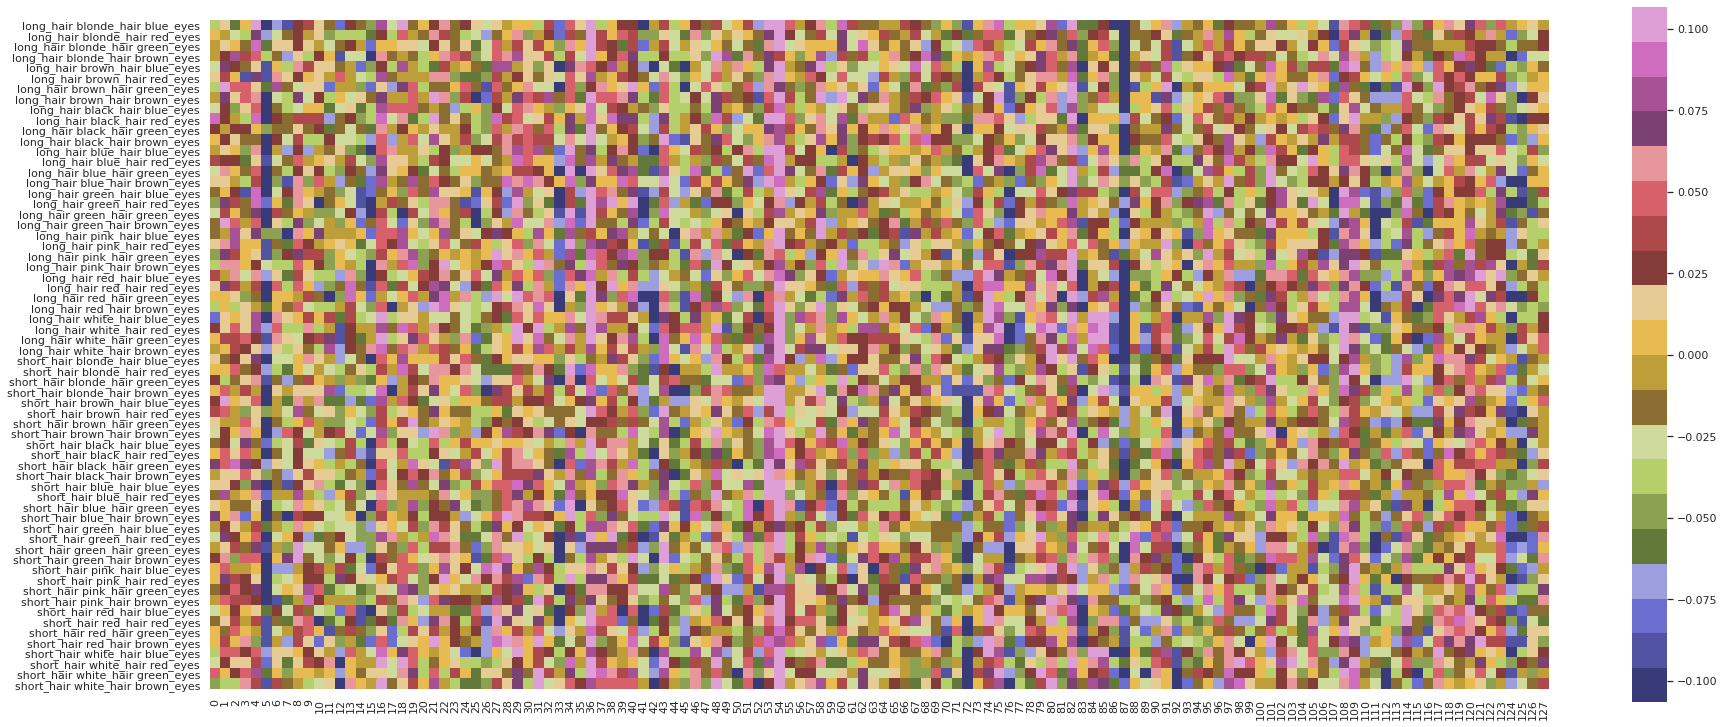

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import io

import itertools
eyes = ['blue_eyes', 'red_eyes', 'green_eyes', 'brown_eyes']#, 'aqua_eyes', 'orange_eyes', 'purple_eyes']
#hair = ['blonde_hair', 'brown_hair', 'black_hair', 'green_hair', 'blue_hair', 'aqua_hair', 'purple_hair', 'pink_hair',  'red_hair', 'silver_hair', 'white_hair']
hair = ['blonde_hair', 'brown_hair', 'black_hair', 'blue_hair', 'green_hair', 'pink_hair',  'red_hair', 'white_hair']
mouth = ['', 'open_mouth']
eye_stuff = ['', 'one_eye_closed']
other = ['', 'animal_ears']
hair_styles = ['long_hair', 'short_hair']
bops = ['one_eye_closed', 'blush', 'smile', 'closed_eyes']

c = list(itertools.product(hair_styles, hair, eyes))
print(len(c))
combs = [" ".join(comb) for comb in c] 

def get_plot_img(ax):
    
    buf = io.BytesIO()
    fig = ax.get_figure()

    fig.savefig(buf, format='png', bbox_inches = 'tight', pad_inches=0.1)
    buf.seek(0)
    im = PIL.Image.open(buf)
    return im


def plot_heatmaps_from_vectors(vecs, tags_list, xticklabels=1, cbar=True, vmin=None, vmax=None, square=True, figsize = None):
    #plt.clf()
    if figsize is None:
        figsize = (30, max(3, len(tags_list)/5))
    sns.set(rc={'figure.figsize':figsize})
    ax = sns.heatmap(vecs, xticklabels=xticklabels, yticklabels=tags_list, robust=True, square=square, cmap='tab20b', cbar=cbar, vmin=vmin, vmax=vmax)
    return ax

def plot_heatmaps_from_tags(tags, cbar=True):
    d = map(lambda x: " ".join('0:' + str(foo) for foo in x.split()), tags)
    tags_list = list(d)
    all_vectors = []
    for i,tagz in enumerate(tags_list):
        sims = model.infer_vector(tagz.split())
        all_vectors.append(sims)
    ax = plot_heatmaps_from_vectors(all_vectors, tags, xticklabels=1, cbar=cbar)
    return ax

plot_heatmaps_from_tags(combs)

# Editor

In [13]:
#@title UI 
import requests
from io import BytesIO

image_filenames = sorted(portrait_files)
seed = widgets.IntSlider(min=0, max=100000, step=1, value=0, description='Seed: ', continuous_update=False)
mu = widgets.FloatSlider(min=-1, max=1, step=0.01, value=0, description='Mu: ', continuous_update=False)
sigma = widgets.FloatSlider(min=0.00, max=1, step=0.01, value=0, description='Sigma: ', continuous_update=False)
truncation = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1, description='Truncation: ', continuous_update=False)
tags_in = widgets.Text(
    value="",
    placeholder="green_eyes red_hair",
    description='Tags:',
    continuous_update=False,
    layout=widgets.Layout(width='1000px'),
)
danbooru_id_slider = widgets.IntSlider(
    min = 0, max = len(image_filenames), value = 0,
    description='Danbooru ID:',
    continuous_update=False,
)
danbooru_id_box = widgets.IntText(continuous_update = False)
link = widgets.jslink((danbooru_id_slider, 'value'), (danbooru_id_box, 'value'))
top_box = widgets.HBox([tags_in])
mid_box = widgets.HBox([danbooru_id_slider, danbooru_id_box])
bot_box = widgets.HBox([seed, mu, sigma, truncation])
ui = widgets.VBox([top_box, bot_box])
ui2 = widgets.VBox([mid_box])
vocab = set(model.wv.vocab.keys())



def value_changed(change):
    danbooru_id_widget.value = change.new

def get_id(filename):
    id_f = filename.split(".")[0]
    return int(id_f[:len(id_f)-1])

def display_sample(tags_in, danbooru_id, seed, mu, sigma, truncation):
    
    new_im = PIL.Image.new('RGB', (1024, 512))
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation is not None:
        Gs_kwargs.truncation_psi = truncation
    rnd = np.random.RandomState(seed)
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    tags_new = ''
    danbooru_index = -1
    use_tags = False

    test_words = []
    invalid_words = []
        
    if len(tags_in) > 10:
        #print("Using tags", len(tags_in))
        tag_set = tags_in.split()
        for tag in tag_set:
            if '*' in tag:
                num = int(tag.split("*")[0])
                for i in range(num):
                    tag_set.append(tag.split("*")[1])
                #tag_set.remove(tag)

        for tag in tag_set:
            # if '*' in tag:
            #     num = int(tag.split("*")[0])
            #     for i in range(num):
            #         tag_set.append(tag.split("*")[1])
            if ':' not in tag:
                for i in range(5):
                    if str(i) + ':' + tag in vocab:
                        tag = str(i) + ':' + tag
                        break
            if tag != '' and tag in vocab:
                test_words.append(tag)
            elif '*' not in tag:
                invalid_words.append(tag)
        labels = model.infer_vector(test_words, alpha=0.025, min_alpha=0.00025, epochs=2000)
        tags_new = test_words
        use_tags = True
        #print(labels)

        #model.mo
        sims = model.docvecs.most_similar(positive=[labels], topn=1000)
        
        print(len(sims))
        #print(sims)
        for n, sim in enumerate(sims):
            d_id, score = sim
            #labels = model.docvecs[d_id]
            #print(str(d_id) + '0.jpg')
            if str(d_id) + '0.jpg' in image_filenames:
                print("TRUE", n, str(d_id))
                danbooru_index = image_filenames.index(str(d_id) + '0.jpg')
                danbooru_id = danbooru_index
                break
        print(danbooru_index)
        #print(sims)
            
    elif danbooru_id >= 0:
        #print(danbooru_id, get_id(image_filenames[danbooru_id]))
        if danbooru_index == -1:
            
            labels = model.docvecs[get_id(image_filenames[danbooru_id])]
        post = client.post_show(get_id(image_filenames[danbooru_id]))
        tags_general = post['tag_string_general'].split()
        tags_character = post['tag_string_character'].split()
        tags_copyright = post['tag_string_copyright'].split()
        for tag in tags_general:
            tags_new = tags_new + '0:' + tag + ' '
        for tag in tags_character:
            tags_new = tags_new + '4:' + tag + ' '
        for tag in tags_copyright:
            tags_new = tags_new + '3:' + tag + ' '
        print(model.docvecs.similarity_unseen_docs(model, test_words, tags_new.split()))
        #print(tags_new)
        
    batch_size = 1
    all_seeds = [seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    #print(all_z.shape)
    if mu != 0 and sigma != 0:
      s = np.random.normal(mu, sigma, 128)
      labels = labels + s
    all_w = Gs.components.mapping.run(all_z, np.tile(labels, (batch_size, 1))) # [minibatch, layer, component]
    #print(all_w.shape)
    if truncation != 1:
        w_avg = Gs.get_var('dlatent_avg')
        all_w = w_avg + (all_w - w_avg) * truncation # [minibatch, layer, component]
        

    l = np.matrix(labels)
    all_images = Gs.run(all_z, l, **Gs_kwargs)
    #all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs)
    new_im.paste(PIL.Image.fromarray(np.median(all_images, axis=0).astype(np.uint8)), (0, 0))
    #display(PIL.Image.fromarray(np.median(all_images, axis=0).astype(np.uint8)))
    
    if int(danbooru_id) > 0 and len(tags_in) < 10:
        response = requests.get('https://battle.shawwn.com/sdc/biggan/portraits/' + image_filenames[danbooru_id])
        old_im = PIL.Image.open(BytesIO(response.content))
        old_id = danbooru_id
        new_im.paste(old_im, (512, 0))
          
        #display(PIL.Image.open(image_filenames[danbooru_id]))

    display(new_im)
    print("Used tags:", tags_new)
    print("Invalid tags:", invalid_words)
    #print(get_id(image_filenames[danbooru_id]))
    if use_tags:
        print('Using tags')
        
    if danbooru_index > 0:
        print("Index:", danbooru_index)
out = widgets.interactive_output(display_sample, {'tags_in': tags_in, 'danbooru_id' : danbooru_id_slider, 'seed': seed, 'mu': mu, 'sigma': sigma, 'truncation': truncation})

display(ui, out, ui2)

Output()

# Interpolation code


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from IPython.display import display, HTML

from IPython.display import HTML

def display_mp4(path):
    print(f'Read from {path}')
    from base64 import b64encode
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))
    print('Display finished.')

In [16]:
import math
from PIL import ImageFont
from PIL import ImageDraw
import io
def generate_video(tags_in_arr, seed, truncation, duration_sec = 10.0, smoothing_sec = 1.0, mp4_fps = 20, filename=None, text=True, heatmaps=False, display=True):
    all_latents = []
    label_names = []
    if tags_in_arr[0] != tags_in_arr[-1]:
        tags_in_arr.append(tags_in_arr[0])
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    synthesis_kwargs = dict(output_transform=Gs_kwargs.output_transform, truncation_psi=truncation, minibatch_size=8)
    if truncation is not None:
        Gs_kwargs.truncation_psi = truncation
    rnd = np.random.RandomState(seed)
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    batch_size = 1
    all_seeds = [seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    all_w = []

    labels = []

    all_labs = []
    all_w_diff = []
    for i, tags_in in enumerate(tags_in_arr):
        #print("Using tags", len(tags_in))
        tag_set = tags_in.split()
        test_words = ['brown_hair', 'long_hair', 'smile', 'blush']
        for tag in tag_set:
            if ':' not in tag:
                for i in range(5):
                    if str(i) + ':' + tag in vocab:
                        tag = str(i) + ':' + tag
                        break
            if tag != '' and tag in vocab:
                test_words.append(tag)
        
        labels_i = model.infer_vector(test_words, alpha=0.025, min_alpha=0.00025, epochs=2000)
        all_w_src = Gs.components.mapping.run(all_z, np.tile(labels_i, (batch_size, 1))) # [minibatch, layer, component]
        if truncation != 1:
            w_avg = Gs.get_var('dlatent_avg')
            all_w_src = w_avg + (all_w_src - w_avg) * truncation # [minibatch, layer, component]
        w_diff = all_w_src - w_avg
        all_w.append(all_w_src)
        all_w_diff.append(w_diff)
        all_labs.append(labels_i)
        
    num_frames = int(np.rint(duration_sec * mp4_fps))
        
    def make_frame(t):
        
        blend = ((len(tags_in_arr)-1)*t/duration_sec)%1.0
        src_i = math.floor((t/duration_sec)*(len(tags_in_arr)-1))
        dst_i = src_i + 1
        #print(t, blend, src_i, dst_i)
        all_w_new = (blend * all_w[dst_i]) + (1 - blend) * all_w[src_i]
        all_images_src = Gs.components.synthesis.run(all_w_new, randomize_noise=False, **synthesis_kwargs)
        all_latents.append(all_w_new[0])
        #all_images_dst = Gs.components.synthesis.run(all_w_dst, randomize_noise=False, **synthesis_kwargs)
        if heatmaps:
            new_im = PIL.Image.new('RGB', (1024, 600))
            new_im.paste(PIL.Image.fromarray(np.median(all_images_src, axis=0).astype(np.uint8)), (0, 0))
            draw = ImageDraw.Draw(new_im)
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", size=22)

            tags_txt = tags_in_arr[dst_i]
            if blend < 0.5:
                tags_txt = tags_in_arr[src_i]
                draw.text((10, 520), "{:0.2f}".format((blend)), (0, 255, 0), font=font)
            else:
                draw.text((10, 520), "{:0.2f}".format((1-blend)), (255, 0, 0), font=font)
            draw.text((60, 520), tags_txt, (255, 255, 255), font=font)
            label_names.append("{:0.2f} {} {:0.2f} {}".format(1-blend, tags_in_arr[src_i], blend, tags_in_arr[dst_i]))

            w_avg = Gs.get_var('dlatent_avg')
            w_diff = all_w_new - w_avg
            vecs = w_diff[0][0].reshape((32, 16))

            plt.clf()
            ax = plot_heatmaps_from_vectors(w_diff[0][0].reshape((32,16)), [], xticklabels=[], vmin=np.amin(all_w_diff), vmax=np.amax(all_w_diff), figsize=(30,30), cbar=False)
            im = get_plot_img(ax)
            im = im.resize((512, 512))
            new_im.paste(im, (512, 0))

            plt.clf()
            ax = plot_heatmaps_from_vectors(all_labs, [], xticklabels=[], cbar=False)
            im2 = get_plot_img(ax)

            im2 = im2.resize((512, 80))
            new_im.paste(im2, (512, 520))

            return np.array(new_im)
        elif text:
            new_im = PIL.Image.new('RGB', (512, 600))
            new_im.paste(PIL.Image.fromarray(np.median(all_images_src, axis=0).astype(np.uint8)), (0, 0))
            draw = ImageDraw.Draw(new_im)
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", size=16)
            draw.text((10, 512), "{:0.2f}".format((1-blend)), (255, 0, 0), font=font)
            draw.text((50, 512), tags_in_arr[src_i], (255, 255, 255), font=font)
            draw.text((10, 550), "{:0.2f}".format((blend)), (0, 255, 0), font=font)
            draw.text((50, 550), tags_in_arr[dst_i], (255, 255, 255), font=font)
            label_names.append("{:0.2f} {} {:0.2f} {}".format(1-blend, tags_in_arr[src_i], blend, tags_in_arr[dst_i]))
            return np.array(new_im)
        else:
            return all_images_src[0]

    
    import moviepy.editor
    mp4_file = 'interp_%s-%s.mp4' % (tags_in_arr, truncation)
    if filename:
        mp4_file = filename
    mp4_codec = 'libx264'
    mp4_bitrate = '5M'

    video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
    video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)
    if display:
        display_mp4(mp4_file)
    print(np.amin(all_w_diff), np.amax(all_w_diff))
    return mp4_file, all_latents, label_names, all_labs
    


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3538944/45929032 bytes (7.7%)7471104/45929032 bytes (16.3%)11403264/45929032 bytes (24.8%)15163392/45929032 bytes (33.0%)19169280/45929032 bytes (41.7%)23248896/45929032 bytes (50.6%)27205632/45929032 bytes (59.2%)31227904/45929032 bytes (68.0%)34054144/45929032 bytes (74.1%)38076416/45929032 bytes (82.9%)42049536/45929032 bytes (91.6%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

 99%|█████████▉| 100/101 [00:28<00:00,  3.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: interp_with_latents.mp4 

Read from interp_with_latents.mp4


Display finished.
-3.7557373 8.686917


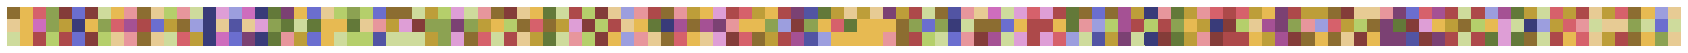

In [17]:
filename, latents, label_names, all_labs = generate_video(['blonde_hair red_eyes long_hair blush', 'blue_hair green_eyes short_hair blush'], 9999, 0.4, duration_sec = 5, filename="interp_with_latents.mp4", heatmaps=True)

In [18]:
#generate_video(['red_eyes', 'red_eyes green_eyes', 'red_eyes', 'yellow_eyes', 'red_eyes', 'red_eyes blue_eyes', 'red_eyes', 'purple_eyes'], 7611, 0.5, duration_sec = 30.0, filename="interp_eye_color_blend_x3.mp4")

In [19]:
#generate_video(['blonde_hair red_eyes', 'blonde_hair green_eyes'], 1000, 0.4, duration_sec = 10.0, filename="interp_eye_color_blend_rg3.mp4")

In [20]:
#generate_video(['brown_hair blue_eyes', 'brown_hair blue_eyes blush', 'black_hair blue_eyes blush', 'black_hair blue_eyes', 'black_hair green_eyes', 'black_hair red_eyes', 'purple_hair red_eyes'], 0, 0.5, duration_sec = 5.0, filename="interp_hair_simple_0.5.mp4")

In [21]:
import itertools
eyes = ['blue_eyes', 'red_eyes', 'green_eyes', 'brown_eyes', 'aqua_eyes', 'orange_eyes', 'purple_eyes']
#hair = ['blonde_hair', 'brown_hair', 'black_hair', 'green_hair', 'blue_hair', 'aqua_hair', 'purple_hair', 'pink_hair',  'red_hair', 'silver_hair', 'white_hair']
hair = ['blonde_hair', 'brown_hair', 'black_hair', 'blue_hair', 'green_hair', 'pink_hair',  'red_hair', 'white_hair']
mouth = ['', 'open_mouth']
eye_stuff = ['', 'one_eye_closed']
other = ['', 'animal_ears']
hair_styles = ['long_hair', 'short_hair']
bops = ['one_eye_closed', 'blush', 'smile', 'closed_eyes']


In [22]:
c = list(itertools.product([hair_styles[1]], other, hair, eyes[:4], mouth, bops))
print(len(c))
combs = [" ".join(comb) for comb in c] 
#generate_video(combs, 0, 0.8, duration_sec = 135, filename="interp_short_hair_d.mp4")

512


In [23]:
c = list(itertools.product(hair_styles, mouth, eye_stuff, hair, eyes[:4]))
print(len(c))
combs = [" ".join(comb) for comb in c] 
#generate_video(combs, 0, 0.9, duration_sec = 140, filename="interp_a.mp4")

256


112
[MoviePy] >>>> Building video interp_with_latents7.mp4
[MoviePy] Writing video interp_with_latents7.mp4


100%|█████████▉| 600/601 [02:33<00:00,  3.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: interp_with_latents7.mp4 

-6.08084 10.118193


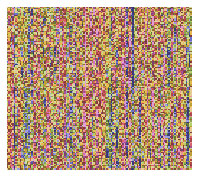

In [24]:
c = list(itertools.product(hair_styles, hair, eyes))
print(len(c))
combs = [" ".join(comb) for comb in c] 
#generate_video(combs, 0, 0.8, duration_sec = 2*60.0, filename="interp_hair_0.8_2.mp4")
filename, latents, label_names, all_labs = generate_video(combs, 5, 0.5, duration_sec = 30, filename="interp_with_latents7.mp4", heatmaps=True, display=False)

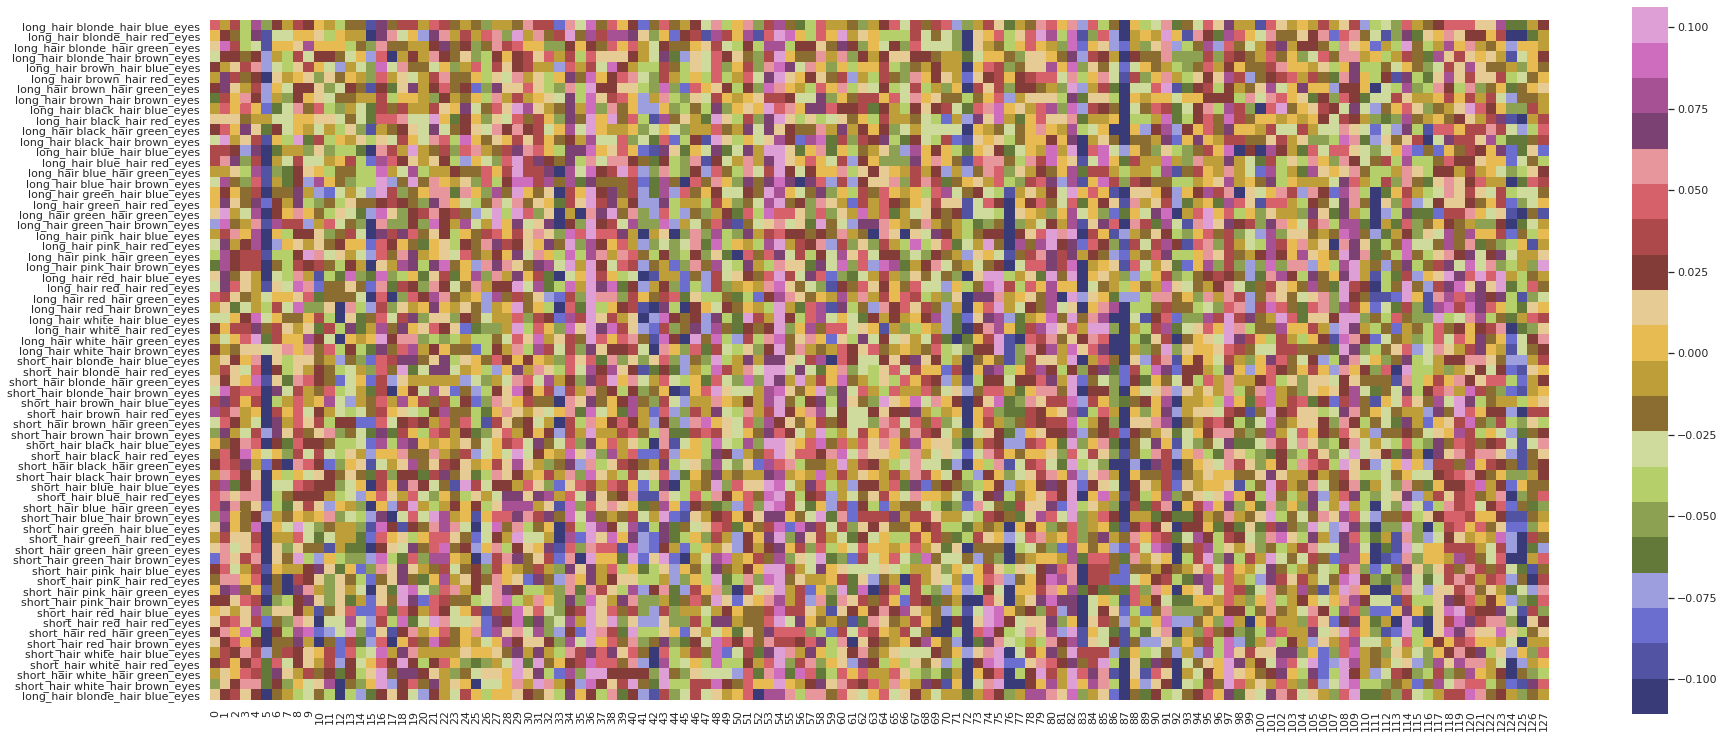

In [ ]:
plot_heatmaps_from_tags(combs)

In [ ]:
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>